In [203]:
import os
from glob import glob
import shutil
from pathlib import Path, PurePath

import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import cv2
from torch.cuda.amp import GradScaler, autocast


from porosityDataset import porosity_Dataset

import torchvision
from torchvision.transforms import transforms as T
from torchvision.utils import draw_bounding_boxes

from tqdm import tqdm

import albumentations as A

import time

%matplotlib inline
torch.manual_seed(42)


In [204]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [205]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [206]:
IMAGES = './train/images'
MASKS = './train/masks'
classes = './train/_classes.csv'

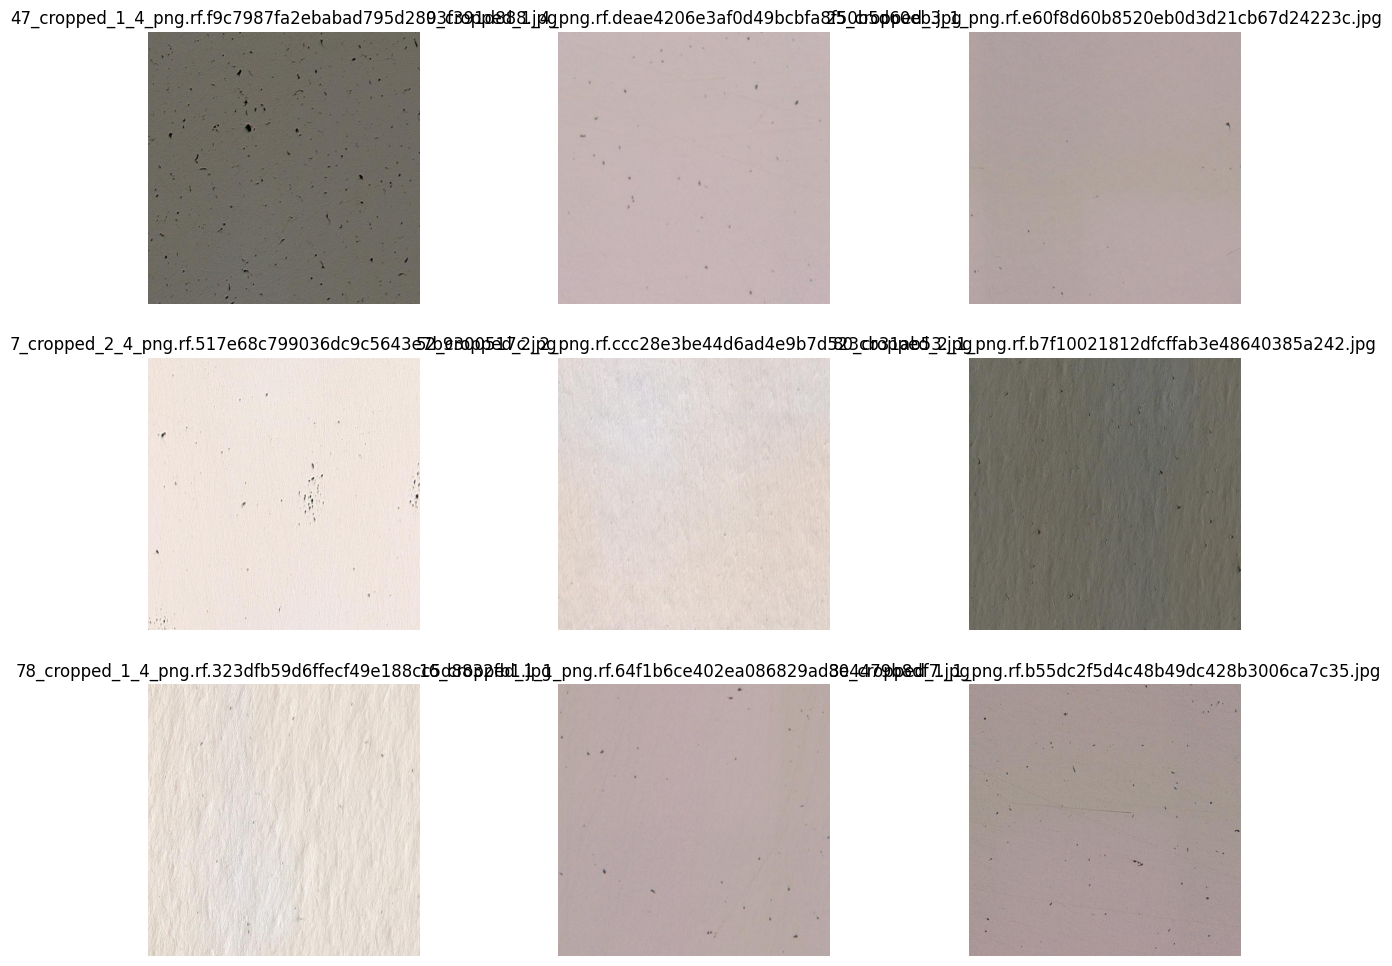

In [207]:
rows, cols = 3, 3
plt.figure(figsize=(15, 12))

image_paths = list(Path(IMAGES).iterdir())
shapes = []

for num, img_path in enumerate(image_paths[:9]):
    with Image.open(img_path) as img:
        shapes.append(img.size)
        plt.subplot(rows, cols, num + 1)
        plt.title(img_path.name)
        plt.axis('off')
        plt.imshow(img)

plt.show()


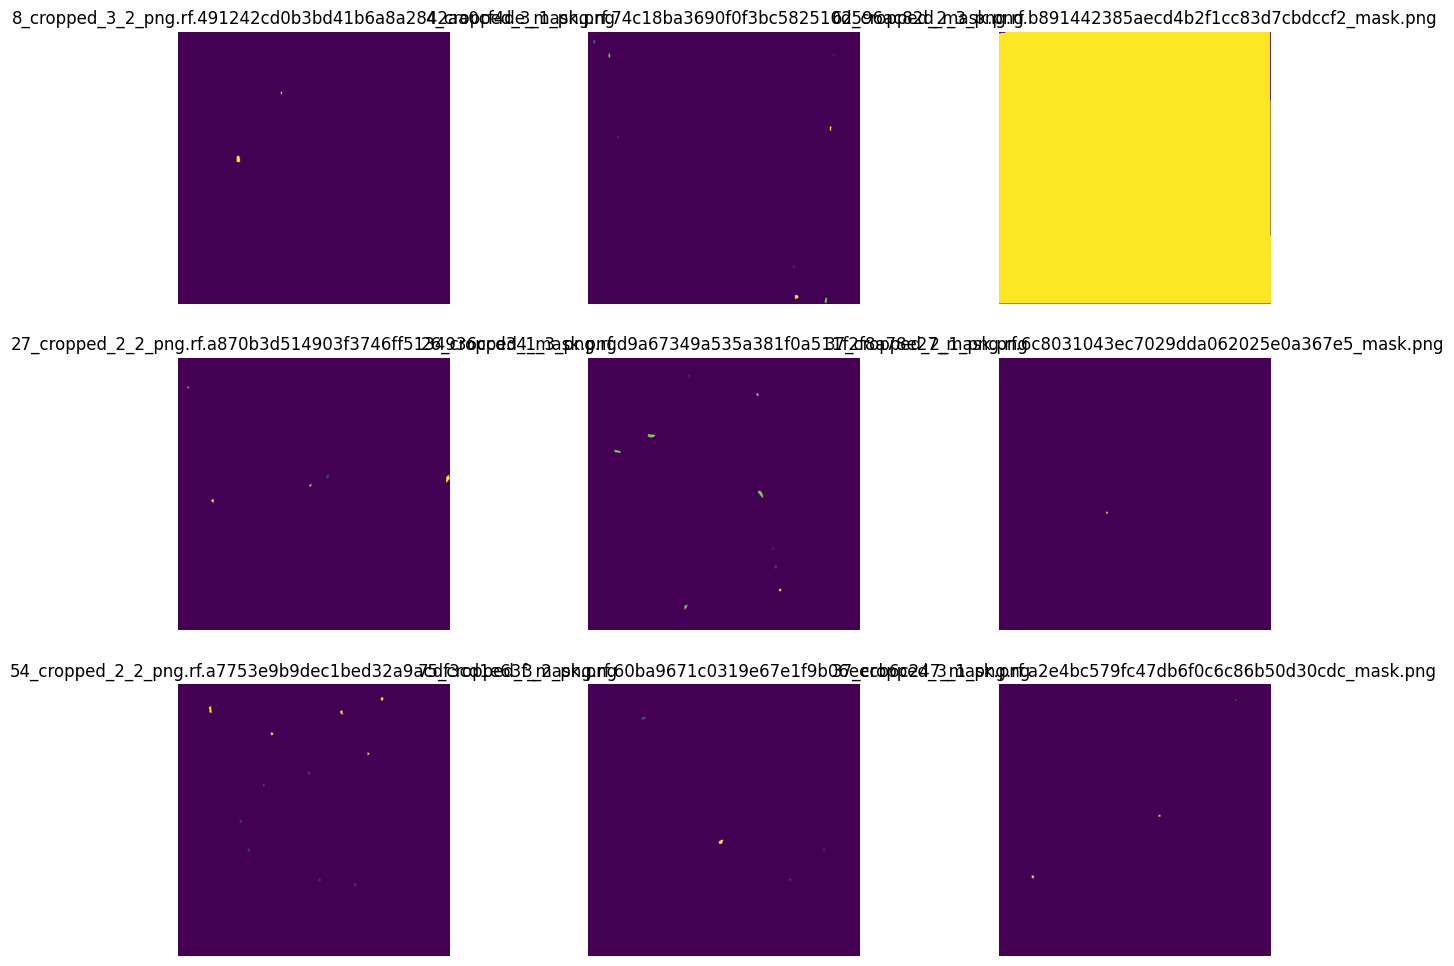

In [208]:
rows, cols = 3, 3
plt.figure(figsize=(15, 12))

masks_paths = list(Path(MASKS).iterdir())
shapes = []

for num, masks_paths in enumerate(masks_paths[:9]):
    with Image.open(masks_paths) as masks:
        shapes.append(masks.size)
        plt.subplot(rows, cols, num + 1)
        plt.title(masks_paths.name)
        plt.axis('off')
        plt.imshow(masks)

plt.show()

In [209]:
size = 256

In [210]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        loss = ((1 - pt) ** self.gamma) * -logpt
        return loss.mean()

In [211]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


t_train = A.Compose([
                    A.VerticalFlip(),
                    A.HorizontalFlip(),
                    A.GridDistortion(p=0.2),
                    A.GaussNoise(),
                    A.RandomBrightnessContrast((0, 0.5), (0, 0.5))
                    ])

t_val = A.Compose([
                    A.HorizontalFlip(),
                    A.GridDistortion(p=0.2)
                   ])

In [212]:
x_all = sorted([os.path.splitext(f)[0] for f in os.listdir(IMAGES)])

In [213]:
# Step 1: Train+Val and Test split
x_temp, x_test = train_test_split(x_all, test_size=0.10, random_state=42, shuffle=True)

# Step 2: Train and Val split from the remaining
x_train, x_val = train_test_split(x_temp, test_size=0.10, random_state=42, shuffle=True)


In [214]:
train_dataset = porosity_Dataset(
    image_path=IMAGES,
    mask_path=MASKS,
    x=x_train,
    mean=mean,
    std=std,
    transform=t_train,
    patch=True,
    image_ext=".jpg",   # images are .jpg
    mask_ext=".png"     # masks are .png
)

val_dataset = porosity_Dataset(
    image_path=IMAGES,
    mask_path=MASKS,
    x=x_val,
    mean=mean,
    std=std,
    transform=t_val,
    patch=True,
    image_ext=".jpg",
    mask_ext=".png"
)
test_dataset = porosity_Dataset(
    image_path=IMAGES,
    mask_path=MASKS,
    x=x_test,
    mean=mean,
    std=std,
    transform=t_val,  # You can use the same val transforms for test
    patch=True,
    image_ext=".jpg",
    mask_ext=".png"
)



In [215]:
def custom_collate(batch):
    # batch is a list of tuples (image_tiles, mask_tiles)
    # Here, image_tiles and mask_tiles can be tensors of variable shapes
    images = [item[0] for item in batch]
    masks = [item[1] for item in batch]
    return images, masks

In [216]:
batch_size = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)


In [217]:
class UNet(nn.Module):
    
    def __init__(self, n_class):
        super().__init__()
       
        
        """
        Encoder 
        
        Every block in encoder has 2 convolution layer followed by max pooling layer, except last block which do not have max pooling layer
        
        The input to the U-Net is 400*400*channels
        
        """
        
        self.enc_blk11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) 
        self.enc_blk12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.enc_blk21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_blk22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.enc_blk31 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc_blk32 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.enc_blk41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc_blk42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.enc_blk51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.enc_blk52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        
        
        """
        Decoder
        Here Upsampling of layers are done
        """
        
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec_blk11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec_blk12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_blk21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec_blk22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_blk31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_blk32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_blk41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_blk42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Output Layer
        self.out_layer = nn.Conv2d(64, n_class, kernel_size=1)
       
    
    
    def forward(self, x):
        
        # Encoder
        enc11 = self.relu(self.enc_blk11(x))
#         print("Encoder block 1 conv layer 1 ", enc11.shape)
        enc12 = self.relu(self.enc_blk12(enc11))
#         print("Encoder block 1 conv layer 2 ",enc12.shape)
        pool1 = self.pool(enc12)
#         print("Encoder block 1 pooling layer ",pool1.shape)
        
        enc21 = self.relu(self.enc_blk21(pool1))
#         print("Encoder block 2 conv layer 1 ",enc21.shape)
        enc22 = self.relu(self.enc_blk22(enc21))
#         print("Encoder block 2 conv layer 2 ",enc22.shape)
        pool2 = self.pool(enc22)
#         print("Encoder block 2 pooling layer ",pool2.shape)
        
        
        enc31 = self.relu(self.enc_blk31(pool2))
#         print("Encoder block 3 conv layer 1 ",enc31.shape)
        enc32 = self.relu(self.enc_blk32(enc31))
#         print("Encoder block 3 conv layer 2 ",enc32.shape)
        pool3 = self.pool(enc32)
#         print("Encoder block 3 pooling layer ",pool3.shape)
        
        enc41 = self.relu(self.enc_blk41(pool3))
#         print("Encoder block 4 conv layer 1 ", enc41.shape)
        enc42 = self.relu(self.enc_blk42(enc41))
#         print("Encoder block 4 conv layer 2 ", enc42.shape)
        pool4 = self.pool(enc42)
#         print("Encoder block 4 pooling layer ", pool4.shape)
        
        enc51 = self.relu(self.enc_blk51(pool4))
#         print("Encoder block 5 conv layer 1 ", enc51.shape)
        enc52 = self.relu(self.enc_blk52(enc51))
#         print("Encoder block 5 conv layer 2", enc52.shape)
        
        # Decoder
        
        up1 = self.upconv1(enc52)
#         print("Upsampling layer 1 ", up1.shape)
        up11 = torch.cat([up1, enc42], dim=1)
#         print("Upsampled value layer 1 ", up11.shape)
        dec11 = self.relu(self.dec_blk11(up11))
#         print("Decoder block 1 conv layer 1 ", dec11.shape)
        dec12 = self.relu(self.dec_blk12(dec11))
        
#         print("Decoder block 1 conv layer 2", dec12.shape)
        
        up2 = self.upconv2(dec12)
#         print("Upsampling layer 2 ", up2.shape)
        up22 = torch.cat([up2, enc32], dim=1)
#         print("Upsampled value layer 2 ", up22.shape)
        dec21 = self.relu(self.dec_blk21(up22))
#         print("Decoder block 2 conv layer 1 ", dec21.shape)
        dec22 = self.relu(self.dec_blk22(dec21))
#         print("Decoder block 2 conv layer 2 ", dec22.shape)
        
        up3 = self.upconv3(dec22)
#         print("Upsampling layer 3 ", up3.shape)
        up33 = torch.cat([up3, enc22], dim=1)
#         print("Upsampled value layer 3 ", up33.shape)
        dec31 = self.relu(self.dec_blk31(up33))
#         print("Decoder block 3 conv layer 1 ", dec31.shape)
        dec32 = self.relu(self.dec_blk32(dec31))
#         print("Decoder block 3 conv layer 2 ", dec32.shape)
        
        up4 = self.upconv4(dec32)
#         print("Upsampling layer 4 ", up4.shape)
        up44 = torch.cat([up4, enc12], dim=1)
#         print("Upsampled value layer 4 ", up44.shape)
        dec41 = self.relu(self.dec_blk41(up44))
#         print("Decoder block 4 conv layer 1 ", dec41.shape)
        dec42 = self.relu(self.dec_blk42(dec41))
#         print("Decoder block 4 conv layer 2 ", dec42.shape)
        
        out = self.out_layer(dec42)
#         print('Output ', out.shape)
       
        
        return out

In [218]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum() / float(correct.numel()))
    return accuracy


In [219]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=5):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        
        iou_per_class = []
        for classes in range(0, n_classes):
            true_class = (pred_mask == classes)
            true_label = (mask == classes)
            
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                
                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [220]:
def compute_per_class_iou(preds, labels, num_classes):
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        union = (pred_inds | label_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

In [221]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    if torch.backends.mps.is_available():
        print("Using MPS (Apple Silicon)")
    elif torch.cuda.is_available():
        print("Using CUDA")

    scaler = GradScaler()  # AMP scaler

    train_losses = []
    val_losses = []
    train_iou = []
    val_iou = []
    train_acc = []
    val_acc = []
    lrs = []
    min_loss = np.inf
    no_improve = 0

    model.to(device)
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()

        model.train()
        running_loss = 0
        running_iou = 0
        running_acc = 0
        total_batches = 0

        for image_tiles, mask_tiles in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()

            if patch:
                images = torch.cat(image_tiles, dim=0).to(device, non_blocking=True)
                masks = torch.cat(mask_tiles, dim=0).to(device, non_blocking=True)
                if masks.dim() == 4 and masks.size(1) == 11:
                    masks = torch.argmax(masks, dim=1)
            else:
                images = image_tiles.to(device, non_blocking=True)
                masks = mask_tiles.to(device, non_blocking=True)
                if masks.dim() == 4 and masks.size(1) == 11:
                    masks = torch.argmax(masks, dim=1)

            with autocast():  # AMP context
                outputs = model(images)
                loss = criterion(outputs, masks)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            running_loss += loss.item()
            running_iou += mIoU(outputs, masks)
            running_acc += pixel_accuracy(outputs, masks)
            total_batches += 1

            lrs.append(get_lr(optimizer))

        # Validation phase
        model.eval()
        val_loss = 0
        val_iou_score = 0
        val_accuracy = 0
        val_batches = 0

        with torch.no_grad():
            for image_tiles, mask_tiles in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                if patch:
                    images = torch.cat(image_tiles, dim=0).to(device, non_blocking=True)
                    masks = torch.cat(mask_tiles, dim=0).to(device, non_blocking=True)
                    if masks.dim() == 4 and masks.size(1) == 11:
                        masks = torch.argmax(masks, dim=1)
                else:
                    images = image_tiles.to(device, non_blocking=True)
                    masks = mask_tiles.to(device, non_blocking=True)
                    if masks.dim() == 4 and masks.size(1) == 11:
                        masks = torch.argmax(masks, dim=1)

                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, masks)

                val_loss += loss.item()
                val_iou_score += mIoU(outputs, masks)
                val_accuracy += pixel_accuracy(outputs, masks)
                val_batches += 1

        avg_train_loss = running_loss / total_batches
        avg_val_loss = val_loss / val_batches
        avg_train_iou = running_iou / total_batches
        avg_val_iou = val_iou_score / val_batches
        avg_train_acc = running_acc / total_batches
        avg_val_acc = val_accuracy / val_batches

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_iou.append(avg_train_iou)
        val_iou.append(avg_val_iou)
        train_acc.append(avg_train_acc)
        val_acc.append(avg_val_acc)

        print(f"Epoch [{epoch + 1}/{epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Train mIoU: {avg_train_iou:.4f}, Val mIoU: {avg_val_iou:.4f}, "
              f"Train Acc: {avg_train_acc:.4f}, Val Acc: {avg_val_acc:.4f}, "
              f"LR: {lrs[-1]:.6f}, "
              f"Time: {(time.time() - epoch_start)/60:.2f} mins")

        # Early stopping and saving model
        if avg_val_loss < min_loss:
            print(f"Validation loss decreased ({min_loss:.4f} -> {avg_val_loss:.4f}). Saving model.")
            min_loss = avg_val_loss
            no_improve = 0
            torch.save(model.state_dict(), 'model.pt')
        else:
            no_improve += 1
            print(f"No improvement in validation loss for {no_improve} epochs.")
            if no_improve >= 7:
                print("Early stopping triggered.")
                break

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    total_time = (time.time() - start_time) / 60
    print(f"Training completed in {total_time:.2f} minutes.")

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_miou': train_iou,
        'val_miou': val_iou,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'lrs': lrs
    }

    return history

In [222]:
model = torch.compile(UNet(11))
model.to(device)


OptimizedModule(
  (_orig_mod): UNet(
    (enc_blk11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc_blk12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
    (enc_blk21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc_blk22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc_blk31): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc_blk32): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc_blk41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc_blk42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc_blk51): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc_blk52): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (upco

In [223]:
def get_class_weights_from_masks(dataset, n_classes):
    all_pixels = []
    for _, mask in tqdm(dataset, desc="Collecting pixel labels"):
        pixels = mask.view(-1).numpy()
        all_pixels.extend(pixels)

    all_pixels = np.array(all_pixels)

    # Find only the classes that are present
    present_classes = np.unique(all_pixels)

    weights = compute_class_weight(
        class_weight='balanced',
        classes=present_classes,
        y=all_pixels
    )

    full_weights = np.ones(n_classes)
    full_weights[present_classes] = weights  # Leave missing classes as weight=1.0

    return torch.tensor(full_weights, dtype=torch.float)

In [224]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

In [225]:
def main():
    # ---- Parameters ----
    batch_size = 3
    epoch = 100
    max_lr = 1e-3
    weight_decay = 1e-2
    n_classes = 11

    # ---- Datasets ----
    train_dataset = porosity_Dataset(
        image_path=IMAGES,
        mask_path=MASKS,
        x=x_train,
        mean=mean,
        std=std,
        transform=t_train,
        patch=True,
        image_ext=".jpg",   # images are .jpg
        mask_ext=".png"     # masks are .png
    )

    val_dataset = porosity_Dataset(
        image_path=IMAGES,
        mask_path=MASKS,
        x=x_val,
        mean=mean,
        std=std,
        transform=t_val,
        patch=True,
        image_ext=".jpg",
        mask_ext=".png"
    )
    test_dataset = porosity_Dataset(
        image_path=IMAGES,
        mask_path=MASKS,
        x=x_test,
        mean=mean,
        std=std,
        transform=t_val,  # You can use the same val transforms for test
        patch=True,
        image_ext=".jpg",
        mask_ext=".png"
    )


    # ---- DataLoaders ----
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=custom_collate, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            collate_fn=custom_collate, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             collate_fn=custom_collate, num_workers=4, pin_memory=True)

    # ---- Device ----
    device = torch.device("cuda" if torch.cuda.is_available() else
                          "mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    # ---- Model ----
    model = UNet(n_classes)
    model = torch.compile(model)  # PyTorch 2.x speed-up
    model.to(device)

    # ---- Loss, Optimizer, Scheduler ----
    weights = get_class_weights_from_masks(train_dataset, n_classes=n_classes).to(device)
    criterion = FocalLoss(weight=weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
                                                    epochs=epoch, steps_per_epoch=len(train_loader))

    # ---- Training ----
    history = fit(epoch, model, train_loader, val_loader, criterion,
                  optimizer, scheduler, patch=True)

    # ---- Plotting ----
    plot_loss(history)
    plot_score(history)
    plot_acc(history)

    # ---- Done ----
    print("Training complete.")

In [226]:
if __name__ == "__main__":
    main()

Using device: mps


NameError: name 'os' is not defined

In [ ]:
def visualize_prediction_sample(image, mask, output, n_classes=11, class_colors=None):
    import matplotlib.pyplot as plt
    import torch.nn.functional as F

    pred = torch.argmax(F.softmax(output.unsqueeze(0), dim=1), dim=1).squeeze(0).cpu()
    image = image.permute(1, 2, 0).cpu()
    mask = mask.cpu()

    if class_colors is None:
        class_colors = torch.randint(0, 255, (n_classes, 3), dtype=torch.uint8)

    def colorize(mask_tensor):
        return class_colors[mask_tensor].numpy().astype('uint8')

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[1].imshow(colorize(mask))
    axes[1].set_title('Ground Truth')
    axes[2].imshow(colorize(pred))
    axes[2].set_title('Prediction')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate(model, test_loader, patch=True, visualize=False, num_visuals=5):
    model.eval()
    test_iou = 0
    test_accuracy = 0

    with torch.no_grad():
        for idx, data in enumerate(tqdm(test_loader, desc="Evaluating")):
            image_tiles, mask_tiles = data

            if patch:
                # Concatenate list of tensors
                images = torch.cat(image_tiles, dim=0).to(device)
                masks = torch.cat(mask_tiles, dim=0).to(device)
            else:
                images = image_tiles.to(device)
                masks = mask_tiles.to(device)

            if masks.dim() == 4 and masks.size(1) == 11:
                masks = torch.argmax(masks, dim=1)

            outputs = model(images)

            test_iou += mIoU(outputs, masks)
            test_accuracy += pixel_accuracy(outputs, masks)

            # Optional: visualize results
            if visualize and idx < num_visuals:
                visualize_prediction_sample(images, outputs, masks)

    print(f"Test mIoU: {test_iou / len(test_loader):.3f}")
    print(f"Test Accuracy: {test_accuracy / len(test_loader):.3f}")

In [ ]:
evaluate(model=model, test_loader=test_loader, patch=True, visualize=True)

NameError: name 'model' is not defined